In [1]:
from mpi4py import MPI
from dolfinx import mesh, plot
import pyvista

import gmsh
from dolfinx.io import gmshio

# Define nelements on each dimension of the domain
nelements = 16; p = 1

# Define the domain and generate a mesh

Info    : Meshing 1D...ence                                                                                               
Info    : [  0%] Meshing curve 5 (Line)
Info    : [ 20%] Meshing curve 8 (Line)
Info    : [ 40%] Meshing curve 9 (Line)
Info    : [ 60%] Meshing curve 10 (Line)
Info    : [ 70%] Meshing curve 11 (Line)
Info    : [ 90%] Meshing curve 12 (Line)
Info    : Done meshing 1D (Wall 0.00054475s, CPU 0.000342s)
Info    : Meshing 2D...
Info    : Meshing surface 1 (Plane, Frontal-Delaunay)
Info    : Done meshing 2D (Wall 0.0151307s, CPU 0.012418s)
Info    : 976 nodes 1956 elements


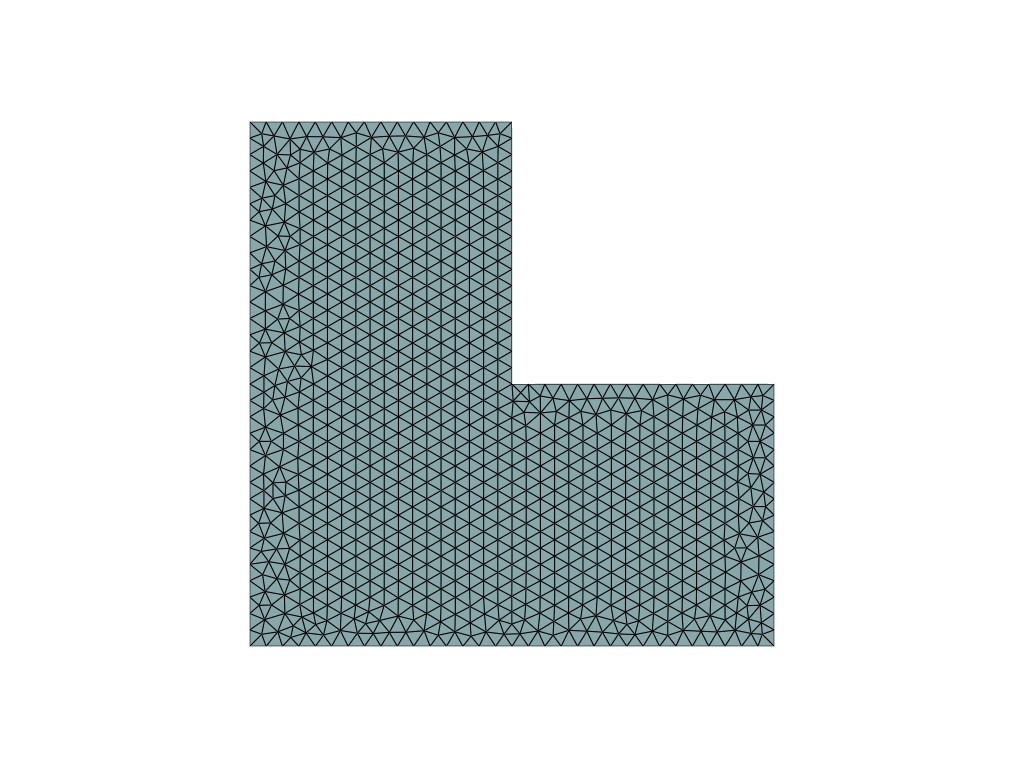

In [2]:
def create_L_shape(comm=MPI.COMM_WORLD, char_len=0.1):
    gmsh.initialize()
    gmsh.model.add("L-shape")

    occ = gmsh.model.occ
    # Outer square (-1,-1) x (1,1)
    outer = occ.addRectangle(-1.0, -1.0, 0.0, 2.0, 2.0)
    # Inner square to remove: [0,1] x [0,1]
    inner = occ.addRectangle(0.0, 0.0, 0.0, 1.0, 1.0)

    # Cut inner from outer -> L shapeß
    (ov, ovmap) = occ.cut([(2, outer)], [(2, inner)], removeObject=True, removeTool=True)
    occ.synchronize()

    # Physical groups: one for cells, one for boundary
    # Cells
    surf_tag = ov[0][1]
    pg_cells = gmsh.model.addPhysicalGroup(2, [surf_tag])
    gmsh.model.setPhysicalName(2, pg_cells, "domain")

    # Boundary facets (all boundary curves together)
    # Get boundary (dimension 1 entities) of the L-shaped surface
    boundary = gmsh.model.getBoundary([(2, surf_tag)], oriented=False, recursive=False)
    curve_tags = [e[1] for e in boundary if e[0] == 1]
    pg_bdry = gmsh.model.addPhysicalGroup(1, curve_tags)
    gmsh.model.setPhysicalName(1, pg_bdry, "boundary")

    # Global target mesh size
    gmsh.option.setNumber("Mesh.CharacteristicLengthMin", char_len)
    gmsh.option.setNumber("Mesh.CharacteristicLengthMax", char_len)

    gmsh.model.mesh.generate(2)

    # Import to dolfinx
    mesh, cell_tags, facet_tags = gmshio.model_to_mesh(
        gmsh.model, comm, 0, gdim=2
    )
    gmsh.finalize()
    return mesh, cell_tags, facet_tags


# load a simple domain
domain, cell_tags, facet_tags = create_L_shape(MPI.COMM_WORLD, char_len=1.0/nelements)

# plotting utilities
pyvista.start_xvfb()
tdim = domain.topology.dim
domain.topology.create_connectivity(tdim, tdim)
topology, cell_types, geometry = plot.vtk_mesh(domain, tdim)
grid = pyvista.UnstructuredGrid(topology, cell_types, geometry)

plotter = pyvista.Plotter()
plotter.add_mesh(grid, show_edges=True)
plotter.view_xy()
if not pyvista.OFF_SCREEN:
    plotter.show()
else:
    figure = plotter.screenshot("triangular_mesh.png")

# Define the weak formulation of the PDE

The PDE we would like to solve is
\begin{align}
-\Delta u = f\ \text{on}\ \Omega,\qquad \text{such that} \qquad u|_{\partial \Omega} = u_D.
\end{align}

Define the test space $V=H^1_0(\Omega)$. Let $\tilde{u} \in H^1$ be some function which satisfies $u|_{\partial \Omega}=u_{D}$.
The variation problem is to find $u\in V+\tilde{u}$ such that
\begin{align}
a(u,v)&=L(v)&& \forall v \in {V},
\end{align}
where the bilinear form and linear functional are defined as
\begin{align}
a(u,v) &= \int_{\Omega} \nabla u \cdot \nabla v~\mathrm{d} x,\\
L(v) &= \int_{\Omega} fv~\mathrm{d} x.
\end{align}

We use the ``method of manufactured solutions'' and choose a function $u_e \in H^1$, then compute $f$ analytically to satisfy the strong form. The solution is
$$u_e=r^{2/3} \sin\left(\frac 2 3 \theta\right).$$
Inserting $u_e$ into the original problem, we find that $-\Delta u = 0$.
The Dirichlet data is given by the restriction of $u_e$ on the boundary.

### Define the bilinear form using UFL
On a chosen finite element space ``Vh'', in this case Lagrange polynomials of order p.

In [3]:
import ufl
from dolfinx import fem, default_scalar_type
from dolfinx.fem.petsc import LinearProblem
import numpy as np

def ue_func(x, eps=1e-15):
    xx, yy = x[0], x[1]
    r = np.maximum(np.sqrt(xx*xx + yy*yy), eps)
    theta = np.arctan2(yy, xx)  # (-pi, pi]
    # Remap so theta ∈ [π/2, 2π+): put the branch cut on the +y axis (θ=π/2), a boundary ray
    theta = np.where(theta < 0.5*np.pi, theta + 2.0*np.pi, theta)
    return (r**(2.0/3.0)) * np.sin((2.0/3.0) * (theta - 0.5*np.pi))

# Finite element space Vh
Vh = fem.functionspace(domain, ("Lagrange", p))

# Body load f
f = fem.Constant(domain, default_scalar_type(0))

# bilinear form and linear functional
u = ufl.TrialFunction(Vh)
v = ufl.TestFunction(Vh)

a = ufl.dot(ufl.grad(u), ufl.grad(v)) * ufl.dx
L = f * v * ufl.dx

### Assign the Dirichlet data

In [4]:
uD = fem.Function(Vh)
uD.interpolate(ue_func)

# Create facet to cell connectißvity required to determine boundary facets
tdim = domain.topology.dim
fdim = tdim - 1
domain.topology.create_connectivity(fdim, tdim)
boundary_facets = mesh.exterior_facet_indices(domain.topology)

boundary_dofs = fem.locate_dofs_topological(Vh, fdim, boundary_facets)
bc = fem.dirichletbc(uD, boundary_dofs)

### Solve the linear system

In [5]:
problem = LinearProblem(a, L, bcs=[bc], petsc_options={"ksp_type": "preonly", "pc_type": "lu"})
uh = problem.solve()

# Compute the error

In [6]:
Vh_refined = fem.functionspace(domain, ("Lagrange", p+3))   # using a refined Vh space 
uex        = fem.Function(Vh_refined)
uex.interpolate(ue_func)

H1_semi_err = fem.form(ufl.inner(ufl.grad(uh - uex), ufl.grad(uh - uex)) * ufl.dx)
err_local   = fem.assemble_scalar(H1_semi_err)
err_H1_semi = np.sqrt(domain.comm.allreduce(err_local, op=MPI.SUM))

L2_error    = fem.form(ufl.inner(uh - uex, uh - uex) * ufl.dx)
error_local = fem.assemble_scalar(L2_error)
error_L2    = np.sqrt(domain.comm.allreduce(error_local, op=MPI.SUM))

error_max = np.max(np.abs(uD.x.array-uh.x.array))
# Only print the error on one process
if domain.comm.rank == 0:
    print(f"Error_H1 : {err_H1_semi+error_L2:.2e}")
    print(f"Error_L2 : {error_L2:.2e}")
    print(f"Error_max : {error_max:.2e}")

Error_H1 : 1.09e-01
Error_L2 : 2.25e-03
Error_max : 1.04e-02


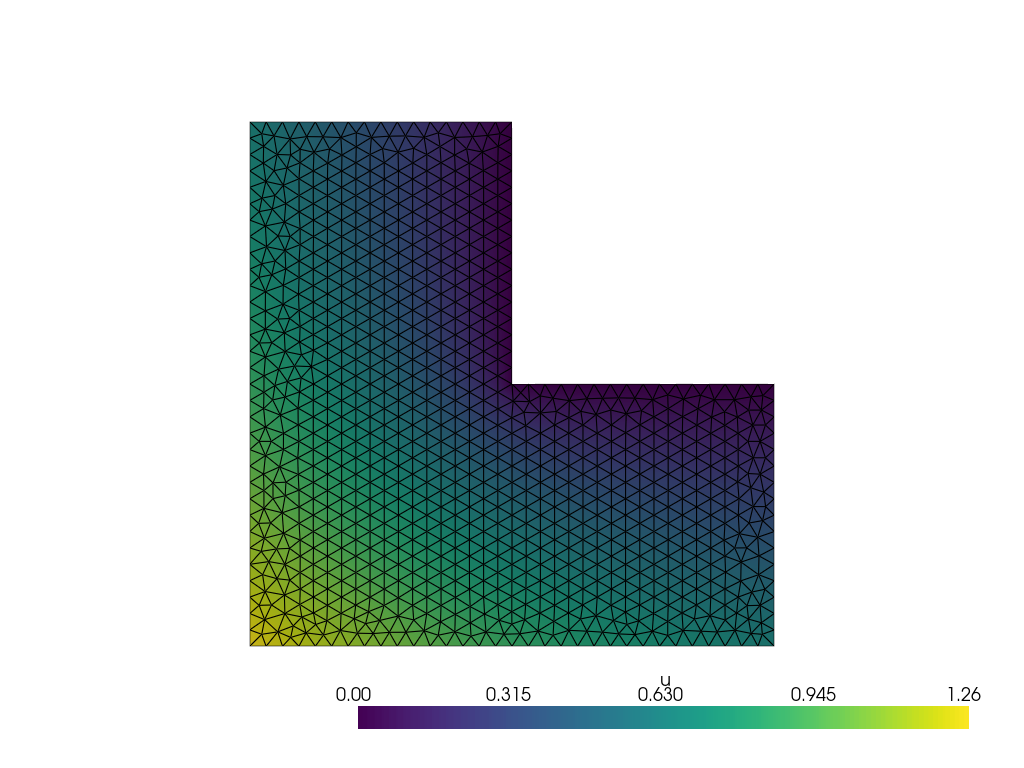

In [7]:
u_topology, u_cell_types, u_geometry = plot.vtk_mesh(Vh)
u_grid = pyvista.UnstructuredGrid(u_topology, u_cell_types, u_geometry)
u_grid.point_data["u"] = uh.x.array.real
u_grid.set_active_scalars("u")
u_plotter = pyvista.Plotter()
u_plotter.add_mesh(u_grid, show_edges=True)
u_plotter.view_xy()
if not pyvista.OFF_SCREEN:
    u_plotter.show()